In [11]:
import pandas as pd
from textblob import TextBlob
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
# import ml_insights as mli


from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
model_data = pd.read_csv('/content/drive/MyDrive/AML Project/fj.csv', index_col = 0,  encoding='utf-8')

indices = model_data.groupby("company_profile").apply(lambda x: [i for i in x.index])
indices.reset_index()

model_data.drop(['job_id','title','salary_range','description','requirements','benefits','company_profile','posting'], axis = 1, inplace = True)

# Get number of unique countries
def getCountry(location):
  return str(location).split(',')[0]

model_data['country'] = model_data['location'].map(getCountry)
countries = model_data['country'].value_counts()
print('The number of unique values in the "country" field is: {}'.format(len(model_data['country'].value_counts())))
model_data.drop(columns = 'location', axis = 1, inplace = True)

# one-hot encoding categorical variables
categorical_cols = ['country', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function'] 
model_data = pd.get_dummies(model_data, columns = categorical_cols)

y = model_data["fraudulent"]
X = model_data.drop('fraudulent', axis = 'columns')

indices_tf = y[[i[0]for i in indices]]

train_idx, test_idx = train_test_split(indices, stratify = indices_tf, test_size=0.20, random_state = 422)

train_idx = np.hstack(train_idx.apply(np.array).values)
test_idx = np.hstack(test_idx.apply(np.array).values)

train_idx.sort()
train_idx

X_train = X.loc[train_idx] 
X_test = X.loc[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

The number of unique values in the "country" field is: 91


# With Pipeline

In [14]:
classifier = AdaBoostClassifier()

smt = SMOTE(random_state=420)

# defining the pipeline
pipeline = Pipeline(steps = [['smote', smt],['classifier', classifier]])

In [15]:
# fitting the pipeline and printing results
pipeline.fit(X_train, y_train) 
y_hat = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2976
           1       0.13      0.17      0.15        76

    accuracy                           0.95      3052
   macro avg       0.55      0.57      0.56      3052
weighted avg       0.96      0.95      0.95      3052



In [16]:
print(confusion_matrix(y_test, y_hat))

[[2890   86]
 [  63   13]]


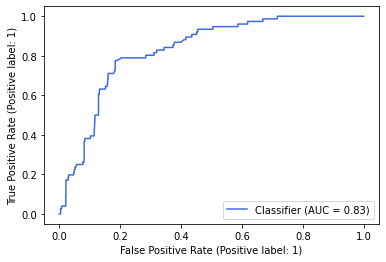

In [17]:
RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1], color='royalblue')

# With GridSearch

In [18]:
# Defining classifier - AdaBoost

DTC = DecisionTreeClassifier(random_state = 11,max_depth = None)



classifier = AdaBoostClassifier(base_estimator = DTC)


param_grid = {'base_estimator__max_depth':[i for i in [1,2,3,4]],
              'n_estimators':[500,1000],
              "random_state": [420],
              'learning_rate':[0.01,0.1]}

# Grid search
ada_grid = GridSearchCV(classifier, param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
ada_grid.fit(X_train, y_train) 
 
# print best parameter after tuning 
print('Best parameters : ',ada_grid.best_params_) 
y_hat = ada_grid.predict(X_test) 
y_pred_proba = ada_grid.predict_proba(X_test)
print(classification_report(y_test,y_hat))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters :  {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 1000, 'random_state': 420}
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2976
           1       0.66      0.38      0.48        76

    accuracy                           0.98      3052
   macro avg       0.82      0.69      0.74      3052
weighted avg       0.98      0.98      0.98      3052



In [19]:
print(confusion_matrix(y_test, y_hat))

[[2961   15]
 [  47   29]]


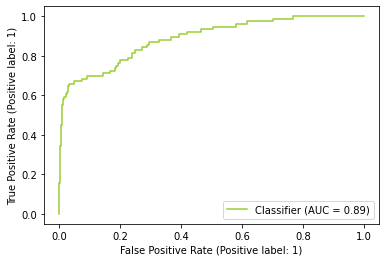

In [21]:
# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba[:, 1], color='yellowgreen')

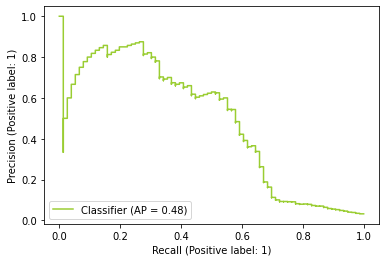

In [22]:
# Precision vs Recall Curve
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba[:, 1], color='yellowgreen')